In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import os
import sys
os.environ["PYSPARK_PYTHON"]='/opt/anaconda/envs/bd9/bin/python'
os.environ["SPARK_HOME"]='/usr/hdp/current/spark2-client'
os.environ["PYSPARK_SUBMIT_ARGS"]='--num-executors 10 --executor-memory 5g --executor-cores 8 --driver-memory 8g pyspark-shell'

spark_home = os.environ.get('SPARK_HOME', None)
if not spark_home:
    raise ValueError('SPARK_HOME environment variable is not set')

sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.7-src.zip'))
exec(open(os.path.join(spark_home, 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.7
      /_/

Using Python version 3.6.5 (default, Apr 29 2018 16:14:56)
SparkSession available as 'spark'.


In [2]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark import Row
# from pyspark.sql.types import ArrayType, StringType, NumericType
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, SparseVector, VectorUDT
from pyspark.ml.feature import *
from pyspark.sql.window import Window
from pyspark.ml.classification import GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.stat import Correlation
from pyspark.ml.recommendation import ALS
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time
import pandas as pd
from datetime import datetime

conf = SparkConf()

spark = (SparkSession
         .builder
         .config(conf=conf)
         .appName("test")
         .getOrCreate())

## Формирование DataFrames

In [3]:
! hdfs dfs -ls /labs/slaba03/

Found 4 items
-rw-r--r--   3 hdfs hdfs   91066524 2022-01-06 18:46 /labs/slaba03/laba03_items.csv
-rw-r--r--   3 hdfs hdfs   29965581 2022-01-06 18:46 /labs/slaba03/laba03_test.csv
-rw-r--r--   3 hdfs hdfs   74949368 2022-01-06 18:46 /labs/slaba03/laba03_train.csv
-rw-r--r--   3 hdfs hdfs  871302535 2022-01-06 18:46 /labs/slaba03/laba03_views_programmes.csv


In [4]:
get_elem = F.udf(lambda x, i: float(x[i]), DoubleType())

In [5]:
path = lambda tab: f'/labs/slaba03/laba03_{tab}.csv'

items_schema = StructType([
    StructField('item_id', IntegerType()),
    StructField('channel_id', FloatType()),
    StructField('datetime_availability_start', DateType()),
    StructField('datetime_availability_stop', DateType()),
    StructField('datetime_show_start', DateType()),
    StructField('datetime_show_stop', DateType()),
    StructField('content_type', IntegerType()),
    StructField('title', StringType()),
    StructField('year', FloatType()),
    StructField('genres', StringType()),
    StructField('region_id', IntegerType()),
])
items = spark.read.csv(path('items'), header = True, sep = '\t', schema = items_schema).drop('region_id')
print('items')
items.show(5)

cv = CountVectorizer(inputCol = 'genres_list', outputCol = 'genres_vector')
items_paid = items.filter(F.col('content_type') == 1)\
.fillna('Прочее', ['genres'])\
.withColumn('genres_list', F.split(F.col('genres'),','))
items_paid = cv.fit(items_paid).transform(items_paid).select('item_id','datetime_availability_start','datetime_availability_stop','title','year','genres_vector')
print('items_paid')
items_paid.show(5)

views_programmes_schema = StructType([
    StructField('user_id', IntegerType()),
    StructField('item_id', IntegerType()),
    StructField('ts_start', LongType()),
    StructField('ts_end', LongType()),
    StructField('item_type', StringType()),
])
views_programmes = spark.read.csv(path('views_programmes'), header = True, sep = ',', schema = views_programmes_schema)\
.withColumn('duration', F.col('ts_end') - F.col('ts_start'))
views_programmes = views_programmes.withColumn("ts_start", views_programmes["ts_start"].cast(TimestampType()))
views_programmes = views_programmes.withColumn("ts_end", views_programmes["ts_end"].cast(TimestampType()))
print('views_programmes')
views_programmes.show(5)

train_schema = StructType([
    StructField('user_id', IntegerType()),
    StructField('item_id', IntegerType()),
    StructField('purchase', IntegerType()),
])
train = spark.read.csv(path('train'), header = True, sep = ',', schema = train_schema)
print('train')
train.show(5)

test = spark.read.csv(path('test'), header = True, sep = ',', schema = train_schema)
print('test')
test.show(5)

items
+-------+----------+---------------------------+--------------------------+-------------------+------------------+------------+--------------------+------+-------+
|item_id|channel_id|datetime_availability_start|datetime_availability_stop|datetime_show_start|datetime_show_stop|content_type|               title|  year| genres|
+-------+----------+---------------------------+--------------------------+-------------------+------------------+------------+--------------------+------+-------+
|  65667|      null|                 1970-01-01|                2018-01-01|               null|              null|           1|на пробах только ...|2013.0|Эротика|
|  65669|      null|                 1970-01-01|                2018-01-01|               null|              null|           1|скуби ду: эротиче...|2011.0|Эротика|
|  65668|      null|                 1970-01-01|                2018-01-01|               null|              null|           1|горячие девочки д...|2011.0|Эротика|
|  65671| 

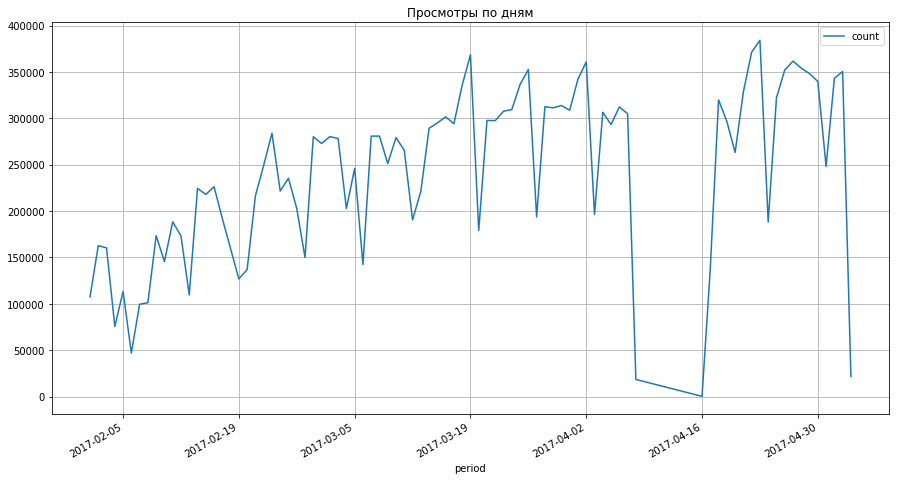

In [6]:
# Просмотры в марте отсутствуют
views_programmes.groupBy(F.date_trunc('Day','ts_start').alias('period')).count().orderBy('period').toPandas().set_index('period')\
.plot(figsize = (15,8), grid = True, title = 'Просмотры по дням');

## Агрегаты по каналам

In [7]:
views_programmes

DataFrame[user_id: int, item_id: int, ts_start: timestamp, ts_end: timestamp, item_type: string, duration: bigint]

In [8]:
n_channels = 100

top_channels = views_programmes.join(items, 'item_id')\
.groupBy('channel_id').agg(F.sum('duration').alias('duration'))\
.orderBy('duration', ascending = False).limit(n_channels)\
.withColumn('channel_rank', F.row_number().over(Window().orderBy(F.col('duration').desc())) - 1)\
.select('channel_id','channel_rank').cache()
top_channels.show(5)

+----------+------------+
|channel_id|channel_rank|
+----------+------------+
|      13.0|           0|
|       5.0|           1|
|      14.0|           2|
|       6.0|           3|
|      12.0|           4|
+----------+------------+
only showing top 5 rows



In [9]:
udf_sparse = F.udf(lambda n, indices, values: SparseVector(n, indices, values), VectorUDT())

In [10]:
w = Window.partitionBy('user_id').orderBy('channel_rank')

channels_agg = views_programmes.join(items, 'item_id').join(top_channels, 'channel_id',)\
.groupBy('user_id', 'channel_rank')\
.agg(F.sum('duration').alias('duration')
     , F.count('duration').alias('count'))\
.withColumn('channel_rank', F.collect_list('channel_rank').over(w))\
.withColumn('duration', F.collect_list('duration').over(w))\
.withColumn('count', F.collect_list('count').over(w))\
.groupBy('user_id')\
.agg(F.max('channel_rank').alias('channel_rank')
     , F.max('duration').alias('duration')
     , F.max('count').alias('count'))\
.withColumn('channel_duration_vector', udf_sparse(F.lit(n_channels), 'channel_rank', 'duration'))\
.withColumn('channel_count_vector', udf_sparse(F.lit(n_channels), 'channel_rank', 'count'))\
.select('user_id','channel_duration_vector', 'channel_count_vector')

durationHint = VectorSizeHint(inputCol = 'channel_duration_vector', size = n_channels)
countHint = VectorSizeHint(inputCol = 'channel_count_vector', size = n_channels)
channels_agg = Pipeline(stages = [durationHint, countHint]).fit(channels_agg).transform(channels_agg).cache()

channels_agg.limit(5).collect()

[Row(user_id=561425, channel_duration_vector=SparseVector(100, {1: 6740.0, 3: 29830.0, 11: 1129.0}), channel_count_vector=SparseVector(100, {1: 1.0, 3: 3.0, 11: 1.0})),
 Row(user_id=612390, channel_duration_vector=SparseVector(100, {5: 4406.0}), channel_count_vector=SparseVector(100, {5: 1.0})),
 Row(user_id=612597, channel_duration_vector=SparseVector(100, {1: 376324.0, 2: 453.0, 3: 132306.0, 4: 50368.0, 5: 2406.0, 8: 29345.0, 10: 12082.0, 11: 6150.0, 13: 14685.0, 17: 544.0, 18: 4404.0, 30: 949.0, 55: 323.0, 56: 1648.0, 61: 28904.0, 65: 490.0, 69: 3776.0, 72: 16303.0, 74: 508.0, 99: 452.0}), channel_count_vector=SparseVector(100, {1: 46.0, 2: 1.0, 3: 35.0, 4: 6.0, 5: 1.0, 8: 2.0, 10: 2.0, 11: 6.0, 13: 1.0, 17: 1.0, 18: 1.0, 30: 1.0, 55: 1.0, 56: 1.0, 61: 15.0, 65: 1.0, 69: 3.0, 72: 2.0, 74: 1.0, 99: 1.0})),
 Row(user_id=632436, channel_duration_vector=SparseVector(100, {1: 218315.0, 3: 1020878.0, 4: 107246.0, 5: 26589.0, 6: 14701.0, 9: 4155.0, 10: 53547.0, 11: 96724.0, 13: 7521.0, 14:

## Агрегаты по телепередачам

In [11]:
n_titles = 100

top_titles = views_programmes.join(items, 'item_id')\
.groupBy('title').agg(F.sum('duration').alias('duration'))\
.orderBy('duration', ascending = False).limit(n_titles)\
.withColumn('title_rank', F.row_number().over(Window().orderBy(F.col('duration').desc())) - 1)\
.select('title','title_rank').cache()
top_titles.show(5)

+--------------------+----------+
|               title|title_rank|
+--------------------+----------+
|               вести|         0|
|"телеканал ""добр...|         1|
|             интерны|         2|
|универ. новая общага|         3|
|            воронины|         4|
+--------------------+----------+
only showing top 5 rows



In [12]:
items.filter(F.col('title') == 'интерны').groupBy('channel_id').count().show(10)

+----------+-----+
|channel_id|count|
+----------+-----+
|      13.0| 6301|
+----------+-----+



In [13]:
bucketizer = Bucketizer(splits=[ 0, 2, 10, 100, float('Inf') ], inputCol = 'count', outputCol = 'buckets')
bucketizer.transform(items.groupBy('title').count()).groupBy('buckets').count().orderBy('buckets').show(20)

+-------+-----+
|buckets|count|
+-------+-----+
|    0.0| 5741|
|    1.0| 9990|
|    2.0| 6857|
|    3.0| 1090|
+-------+-----+



In [14]:
items.rdd.getNumPartitions()

22

In [15]:
w = Window.partitionBy('user_id').orderBy('title_rank')

titles_agg = views_programmes.join(items, 'item_id').join(top_titles, 'title')\
.groupBy('user_id', 'title_rank')\
.agg(F.sum('duration').alias('duration')
     , F.count('duration').alias('count'))\
.withColumn('title_rank', F.collect_list('title_rank').over(w))\
.withColumn('duration', F.collect_list('duration').over(w))\
.withColumn('count', F.collect_list('count').over(w))\
.groupBy('user_id')\
.agg(F.max('title_rank').alias('title_rank')
     , F.max('duration').alias('duration')
     , F.max('count').alias('count'))\
.withColumn('title_duration_vector', udf_sparse(F.lit(n_titles), 'title_rank', 'duration'))\
.withColumn('title_count_vector', udf_sparse(F.lit(n_titles), 'title_rank', 'count'))\
.select('user_id','title_duration_vector', 'title_count_vector')

durationHint = VectorSizeHint(inputCol = 'title_duration_vector', size = n_titles)
countHint = VectorSizeHint(inputCol = 'title_count_vector', size = n_titles)
titles_agg = Pipeline(stages = [durationHint, countHint]).fit(titles_agg).transform(titles_agg).cache()

titles_agg.limit(5).collect()

[Row(user_id=561425, title_duration_vector=SparseVector(100, {0: 15128.0}), title_count_vector=SparseVector(100, {0: 2.0})),
 Row(user_id=612597, title_duration_vector=SparseVector(100, {0: 26589.0, 1: 14680.0, 6: 14700.0, 9: 43807.0, 10: 4652.0, 15: 21995.0, 16: 2401.0, 25: 131026.0, 27: 11408.0, 30: 32985.0, 36: 529.0, 39: 4350.0, 46: 45530.0, 47: 3420.0, 48: 2925.0, 52: 4229.0, 56: 9457.0, 63: 14698.0, 81: 1220.0, 98: 29365.0}), title_count_vector=SparseVector(100, {0: 13.0, 1: 1.0, 6: 1.0, 9: 2.0, 10: 4.0, 15: 3.0, 16: 1.0, 25: 9.0, 27: 5.0, 30: 3.0, 36: 1.0, 39: 5.0, 46: 3.0, 47: 1.0, 48: 2.0, 52: 4.0, 56: 1.0, 63: 1.0, 81: 2.0, 98: 2.0})),
 Row(user_id=632436, title_duration_vector=SparseVector(100, {0: 228161.0, 1: 8053.0, 6: 85607.0, 9: 10416.0, 12: 62886.0, 14: 4973.0, 16: 6250.0, 17: 15405.0, 20: 3528.0, 21: 14476.0, 22: 2004.0, 27: 97036.0, 32: 3213.0, 39: 128662.0, 42: 358.0, 46: 1187.0, 52: 10630.0, 54: 31211.0, 56: 11538.0, 59: 1267.0, 60: 4629.0, 65: 8745.0, 69: 21353.0,

## Агрегаты по периодам

In [16]:
periods_stat = views_programmes\
.groupBy(F.date_trunc('Week', 'ts_start').alias('period'))\
.agg(F.sum('duration').alias('duration'))\
.orderBy('period')\
.withColumn('period_rank', F.row_number().over(Window().orderBy(F.col('duration').desc())) - 1)\
.select('period','period_rank').cache()
n_periods = periods_stat.count()
periods_stat.show(100)

+-------------------+-----------+
|             period|period_rank|
+-------------------+-----------+
|2017-03-13 00:00:00|          0|
|2017-03-27 00:00:00|          1|
|2017-04-17 00:00:00|          2|
|2017-03-20 00:00:00|          3|
|2017-04-24 00:00:00|          4|
|2017-02-27 00:00:00|          5|
|2017-03-06 00:00:00|          6|
|2017-02-20 00:00:00|          7|
|2017-04-03 00:00:00|          8|
|2017-02-13 00:00:00|          9|
|2017-02-06 00:00:00|         10|
|2017-05-01 00:00:00|         11|
|2017-01-30 00:00:00|         12|
|2017-04-10 00:00:00|         13|
+-------------------+-----------+



In [17]:
w = Window.partitionBy('user_id').orderBy('period_rank')

periods_agg = views_programmes.withColumn('period', F.date_trunc('Week', 'ts_start'))\
.join(items, 'item_id').join(periods_stat, 'period')\
.groupBy('user_id', 'period_rank')\
.agg(F.sum('duration').alias('duration')
     , F.count('duration').alias('count'))\
.withColumn('period_rank', F.collect_list('period_rank').over(w))\
.withColumn('duration', F.collect_list('duration').over(w))\
.withColumn('count', F.collect_list('count').over(w))\
.groupBy('user_id')\
.agg(F.max('period_rank').alias('period_rank')
     , F.max('duration').alias('duration')
     , F.max('count').alias('count'))\
.withColumn('period_duration_vector', udf_sparse(F.lit(n_periods), 'period_rank', 'duration'))\
.withColumn('period_count_vector', udf_sparse(F.lit(n_periods), 'period_rank', 'count'))\
.select('user_id','period_duration_vector', 'period_count_vector')

durationHint = VectorSizeHint(inputCol = 'period_duration_vector', size = n_periods)
countHint = VectorSizeHint(inputCol = 'period_count_vector', size = n_periods)
periods_agg = Pipeline(stages = [durationHint, countHint]).fit(titles_agg).transform(periods_agg).cache()

periods_agg.limit(5).collect()

[Row(user_id=561425, period_duration_vector=SparseVector(14, {3: 30959.0, 7: 6740.0}), period_count_vector=SparseVector(14, {3: 4.0, 7: 1.0})),
 Row(user_id=612390, period_duration_vector=SparseVector(14, {7: 4406.0}), period_count_vector=SparseVector(14, {7: 1.0})),
 Row(user_id=612597, period_duration_vector=SparseVector(14, {0: 48810.0, 1: 70076.0, 2: 44578.0, 3: 47908.0, 4: 61952.0, 5: 17190.0, 6: 123850.0, 7: 28882.0, 8: 65069.0, 9: 73030.0, 10: 63789.0, 11: 35833.0, 12: 5790.0}), period_count_vector=SparseVector(14, {0: 7.0, 1: 17.0, 2: 4.0, 3: 4.0, 4: 22.0, 5: 8.0, 6: 13.0, 7: 11.0, 8: 8.0, 9: 18.0, 10: 14.0, 11: 4.0, 12: 1.0})),
 Row(user_id=632436, period_duration_vector=SparseVector(14, {0: 223776.0, 1: 192290.0, 2: 162993.0, 3: 244144.0, 4: 171056.0, 5: 142112.0, 6: 148629.0, 7: 115438.0, 8: 132716.0, 9: 89646.0, 10: 78293.0, 11: 53519.0, 12: 25871.0}), period_count_vector=SparseVector(14, {0: 55.0, 1: 51.0, 2: 25.0, 3: 40.0, 4: 43.0, 5: 21.0, 6: 25.0, 7: 28.0, 8: 20.0, 9: 1

## Агрегаты по просмотрам

In [18]:
views_agg = views_programmes.groupBy('user_id')\
.agg(F.sum('duration').alias('duration_total')
     , F.sum(F.when(F.col('item_type') == 'live', F.col('duration')).otherwise(0)).alias('duration_live')
     , F.sum(F.when(F.col('item_type') == 'pvr', F.col('duration')).otherwise(0)).alias('duration_pvr')
     , F.min('ts_start').cast('long').alias('start_dt')
     , F.max('ts_start').cast('long').alias('end_dt')
    )\
.withColumn('length_dt', F.col('end_dt') - F.col('start_dt')).cache()
views_agg.show(5)

+-------+--------------+-------------+------------+----------+----------+---------+
|user_id|duration_total|duration_live|duration_pvr|  start_dt|    end_dt|length_dt|
+-------+--------------+-------------+------------+----------+----------+---------+
| 753966|       2305138|      2295379|        9759|1486456849|1493830140|  7373291|
| 754230|       2256455|       935592|     1320863|1485931911|1493856301|  7924390|
| 761341|        112461|        21729|       90732|1489132663|1493808022|  4675359|
| 761571|        527877|       518212|        9665|1485927946|1493843990|  7916044|
| 764437|        159821|       159821|           0|1486195850|1491510627|  5314777|
+-------+--------------+-------------+------------+----------+----------+---------+
only showing top 5 rows



## Агрегаты по платным фильмам

In [19]:
purchase_rate_by_item = train\
.groupBy('item_id')\
.agg(F.mean('purchase').alias('purchase_rate_by_item'), F.count('purchase').alias('users'), F.sum('purchase').alias('purchased'))\
.orderBy('item_id').cache()
purchase_rate_by_item.show(10)
purchase_rate_by_item.count()

+-------+---------------------+-----+---------+
|item_id|purchase_rate_by_item|users|purchased|
+-------+---------------------+-----+---------+
|    326| 7.320644216691069E-4| 1366|        1|
|    336|                  0.0| 1377|        0|
|    357| 7.401924500370096E-4| 1351|        1|
|    396| 7.326007326007326E-4| 1365|        1|
|    400| 7.215007215007215E-4| 1386|        1|
|    423| 7.336757153338225E-4| 1363|        1|
|    430| 7.645259938837921E-4| 1308|        1|
|    449| 7.407407407407407E-4| 1350|        1|
|    453|                  0.0| 1359|        0|
|    478| 0.001447178002894356| 1382|        2|
+-------+---------------------+-----+---------+
only showing top 10 rows



3704

In [20]:
purchase_rate_by_title = train.join(items, 'item_id')\
.groupBy('title')\
.agg(F.mean('purchase').alias('purchase_rate_by_title'), F.count('purchase').alias('users'), F.sum('purchase').alias('purchased'))\
.orderBy('title').cache()
purchase_rate_by_title.show(10)
purchase_rate_by_title.count()

+--------------------+----------------------+-----+---------+
|               title|purchase_rate_by_title|users|purchased|
+--------------------+----------------------+-----+---------+
|"тайна ""волчьей ...|  7.385524372230429E-4| 1354|        1|
|        #selfieparty|   7.49063670411985E-4| 1335|        1|
|   (не)жданный принц|  7.331378299120235E-4| 2728|        2|
|      +1 (плюс один)|                   0.0| 1348|        0|
|                 1+1|  0.002592592592592...| 2700|        7|
|  1+1 (сурдоперевод)|  7.283321194464676E-4| 1373|        1|
|  1+1 дом. новый год|  0.001452432824981...| 1377|        2|
|   1+1 дома: 8 марта|  0.001433691756272...| 1395|        2|
|   10 друзей кролика|  0.003695491500369549| 1353|        5|
|10 лучших игр по ...|  7.396449704142012E-4| 1352|        1|
+--------------------+----------------------+-----+---------+
only showing top 10 rows



2914

In [21]:
purchase_rate_by_user = train\
.groupBy('user_id')\
.agg(F.mean('purchase').alias('purchase_rate_by_user'), F.count('purchase').alias('items'), F.sum('purchase').alias('purchased'))\
.orderBy('user_id').cache()
purchase_rate_by_user.show(10)
purchase_rate_by_user.count()

+-------+---------------------+-----+---------+
|user_id|purchase_rate_by_user|items|purchased|
+-------+---------------------+-----+---------+
|   1654| 0.001947040498442...| 2568|        5|
| 510087| 0.002363135092556...| 2539|        6|
| 517612| 3.901677721420211E-4| 2563|        1|
| 520446| 0.003053435114503...| 2620|        8|
| 522798|          0.001171875| 2560|        3|
| 523860| 0.013026819923371647| 2610|       34|
| 529632| 3.874467260751647E-4| 2581|        1|
| 556825| 0.003117692907248636| 2566|        8|
| 566701| 0.004610065309258548| 2603|       12|
| 566758| 3.766478342749529E-4| 2655|        1|
+-------+---------------------+-----+---------+
only showing top 10 rows



1941

In [22]:
items.filter(F.col('item_id').isin([540,74605])).show()

+-------+----------+---------------------------+--------------------------+-------------------+------------------+------------+-----------------+------+--------------------+
|item_id|channel_id|datetime_availability_start|datetime_availability_stop|datetime_show_start|datetime_show_stop|content_type|            title|  year|              genres|
+-------+----------+---------------------------+--------------------------+-------------------+------------------+------------+-----------------+------+--------------------+
|    540|      null|                 1970-01-01|                2099-12-31|               null|              null|           1|мой парень – псих|2012.0|Комедии,Драмы,Мел...|
|  74605|      null|                 1970-01-01|                2099-12-31|               null|              null|           1|мой парень – псих|2012.0|Комедии,Драмы,Мел...|
+-------+----------+---------------------------+--------------------------+-------------------+------------------+------------+---

## Наивные модели на данных только train превосходят baseline

In [23]:
feature_evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'purchase_rate_by_item', labelCol = 'purchase', metricName = 'areaUnderROC')

np.abs(2 * feature_evaluator.evaluate(train.join(purchase_rate_by_item, 'item_id')) - 1)

0.6553423101726221

In [24]:
naive_df_1 = test.join(purchase_rate_by_item, 'item_id')\
.select('user_id','item_id', F.col('purchase_rate_by_item').alias('purchase'))\
.orderBy('user_id','item_id').toPandas()

In [25]:
# ROC AUC: 0.74543428073
# filename = f'lab03_{datetime.now().strftime("%Y-%m-%d_%H%M%S")}.csv'
# print(filename)
# naive_df_1.to_csv(filename, index = False)

In [26]:
# ! cp lab03_2022-10-23_010414.csv lab03.csv

In [27]:
naive_df_2 = test.join(items, 'item_id').join(purchase_rate_by_title, 'title')\
.select('user_id','item_id', F.col('purchase_rate_by_title').alias('purchase'))\
.orderBy('user_id','item_id').toPandas()

In [28]:
# ROC AUC: 0.745522236992
# filename = f'lab03_{datetime.now().strftime("%Y-%m-%d_%H%M%S")}.csv'
# print(filename)
# naive_df_2.to_csv(filename, index = False)

In [29]:
# ! cp lab03_2022-10-23_010936.csv lab03.csv

In [30]:
naive_df_3 = test.join(purchase_rate_by_user, 'user_id')\
.select('user_id','item_id', F.col('purchase_rate_by_user').alias('purchase'))\
.orderBy('user_id','item_id').toPandas()

In [31]:
# ROC AUC: 0.809270685737
# filename = f'lab03_{datetime.now().strftime("%Y-%m-%d_%H%M%S")}.csv'
# print(filename)
# naive_df_3.to_csv(filename, index = False)

In [32]:
# ! cp lab03_2022-10-23_114659.csv lab03.csv

In [33]:
eps = 1e-10
logit = F.udf(lambda p: float(np.log((p + eps)/(1 - p + eps))), DoubleType())

In [34]:
naive_logreg_train = train.join(purchase_rate_by_user, 'user_id').join(purchase_rate_by_item, 'item_id')\
.select(train['user_id'], train['item_id'], 'purchase', 'purchase_rate_by_user', 'purchase_rate_by_item'
        , logit('purchase_rate_by_user').alias('user_woe')
        , logit('purchase_rate_by_item').alias('item_woe'))

vecAssembler = VectorAssembler(inputCols = ['user_woe','item_woe'], outputCol = 'woes')
naive_logreg_train = vecAssembler.transform(naive_logreg_train).cache()

In [35]:
naive_logreg_train.show(5)

+-------+-------+--------+---------------------+---------------------+------------------+------------------+--------------------+
|user_id|item_id|purchase|purchase_rate_by_user|purchase_rate_by_item|          user_woe|          item_woe|                woes|
+-------+-------+--------+---------------------+---------------------+------------------+------------------+--------------------+
|   1654|  74107|       0| 0.001947040498442...| 7.575757575757576E-4|-6.239495762670167|-7.184629020817399|[-6.2394957626701...|
|   1654|  89249|       0| 0.001947040498442...| 0.001473839351510...|-6.239495762670167|-6.518409485004006|[-6.2394957626701...|
|   1654|  99982|       0| 0.001947040498442...| 0.001480384900074...|-6.239495762670167|-6.513971608197961|[-6.2394957626701...|
|   1654|  89901|       0| 0.001947040498442...| 7.336757153338225E-4|-6.239495762670167| -7.21670935050954|[-6.2394957626701...|
|   1654| 100504|       0| 0.001947040498442...| 0.004964539007092199|-6.239495762670167| 

In [36]:
naive_logreg = LogisticRegression(featuresCol = 'woes', labelCol = 'purchase').fit(naive_logreg_train)

In [37]:
naive_logreg.coefficients

DenseVector([1.0488, 1.0462])

In [38]:
naive_logreg_test = test.join(purchase_rate_by_user, 'user_id').join(purchase_rate_by_item, 'item_id')\
.select(test['user_id'], test['item_id'], 'purchase', 'purchase_rate_by_user', 'purchase_rate_by_item'
        , logit('purchase_rate_by_user').alias('user_woe')
        , logit('purchase_rate_by_item').alias('item_woe'))

vecAssembler = VectorAssembler(inputCols = ['user_woe','item_woe'], outputCol = 'woes')
naive_logreg_test = vecAssembler.transform(naive_logreg_test).cache()

In [39]:
naive_df_4 = naive_logreg.transform(naive_logreg_test).select('user_id', 'item_id', get_elem('probability', F.lit(1)).alias('purchase'))\
.orderBy('user_id', 'item_id').toPandas()

In [40]:
# ROC AUC: 0.800856591558
# filename = f'lab03_{datetime.now().strftime("%Y-%m-%d_%H%M%S")}.csv'
# print(filename)
# naive_df_4.to_csv(filename, index = False)

In [41]:
# ! cp lab03_2022-10-23_123913.csv lab03.csv

## Рекомендательная система на базе ALS

In [42]:
# train.show(5)

In [43]:
# als = ALS(rank = 2, seed = 0, maxIter = 20, userCol = 'user_id', itemCol = 'item_id', ratingCol = 'purchase')
# recommender = als.fit(train)

In [44]:
# rec_train = recommender.transform(train).withColumn('prediction', F.col('prediction').cast('double')).cache()

In [45]:
# rec_train.count()

In [46]:
# feature_evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'prediction', labelCol = 'purchase', metricName = 'areaUnderROC')

# np.abs(2 * feature_evaluator.evaluate(rec_train) - 1)

In [47]:
# recommender_df =  recommender.transform(test)\
# .select('user_id', 'item_id', F.col('prediction').alias('purchase')).orderBy('user_id', 'item_id').toPandas()

In [48]:
# ROC AUC: 0.800856591558
# filename = f'lab03_{datetime.now().strftime("%Y-%m-%d_%H%M%S")}.csv'
# print(filename)
# recommender_df.to_csv(filename, index = False)

## Сбор датасетов для обучения бустинга

In [49]:
feats = train.join(views_agg, 'user_id', 'left').join(periods_agg, 'user_id', 'left')\
.join(channels_agg, 'user_id', 'left').join(titles_agg, 'user_id', 'left').join(items_paid, 'item_id', 'left')\
.join(purchase_rate_by_user, 'user_id').join(purchase_rate_by_item, 'item_id')

feats_list = [col for col in feats.columns if '_vector' in col] + [col for col in views_agg.columns if col != 'user_id'] + ['purchase_rate_by_user', 'purchase_rate_by_item']

vecAssembler = VectorAssembler(inputCols = feats_list
                               , outputCol = 'features' 
                               , handleInvalid = 'keep')
feats = vecAssembler.transform(feats).cache()

feats.show(1, vertical = True)

-RECORD 0-------------------------------------------
 item_id                     | 8389                 
 user_id                     | 768889               
 purchase                    | 0                    
 duration_total              | 2114108              
 duration_live               | 1980425              
 duration_pvr                | 133683               
 start_dt                    | 1486052154           
 end_dt                      | 1493844900           
 length_dt                   | 7792746              
 period_duration_vector      | (14,[0,1,2,3,4,5,... 
 period_count_vector         | (14,[0,1,2,3,4,5,... 
 channel_duration_vector     | (100,[0,1,2,3,4,5... 
 channel_count_vector        | (100,[0,1,2,3,4,5... 
 title_duration_vector       | (100,[0,2,3,4,5,1... 
 title_count_vector          | (100,[0,2,3,4,5,1... 
 datetime_availability_start | 1970-01-01           
 datetime_availability_stop  | 2099-12-31           
 title                       | пес в сапогах (

In [50]:
train_feats = feats.sampleBy('purchase', fractions={0: 0.8, 1: 0.8}, seed=5757).coalesce(10).cache()
valid_feats = feats.join(train_feats, on= ['user_id', 'item_id'] , how="leftanti").coalesce(10).cache()

## Обучение модели бустинга

In [51]:
get_elem = F.udf(lambda x, i: float(x[i]), DoubleType())

In [52]:
feature_evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'feat', labelCol = 'purchase', metricName = 'areaUnderROC')
small_df = train_feats.select('features', 'purchase').sampleBy('purchase', {0: 0.01, 1: 1}).cache()
n_feats = small_df.select('features').limit(1).collect()[0]['features'].size
print(n_feats)

520


In [53]:
# Снижение размерности
gini_dict = {}
# start_time = time.time()
# for i in range(n_feats):
# #     print(i)
#     test_feature = small_df.withColumn('feat', get_elem('features', F.lit(i)))
#     gini_dict[i] = np.abs(2 * feature_evaluator.evaluate(test_feature) - 1)
# print(f'{(time.time() - start_time)/60} minutes')

In [54]:
# best_indices = [item[0] for item in gini_dict.items() if (item[1] > 0.1) & (item[1] < 0.6)]
best_indices = list(range(n_feats))
vs = VectorSlicer(inputCol = 'features', outputCol = 'features_short', indices = best_indices)
print(f'Обучаем на {len(best_indices)} фичах')

Обучаем на 520 фичах


In [55]:
train_feats_short = vs.transform(train_feats).select('features_short', 'purchase').cache()
valid_feats_short = vs.transform(valid_feats).select('features_short', 'purchase').cache()

In [56]:
valid_feats_short

DataFrame[features_short: vector, purchase: int]

In [ ]:
start_time = time.time()
gbt = GBTClassifier(maxIter = 22, maxDepth = 5, featuresCol = 'features_short', labelCol = 'purchase', seed = 42)
model = gbt.fit(train_feats_short)
print(f'{(time.time() - start_time)/60} minutes')

In [58]:
# train_predictions = model.transform(train_feats_short).cache()
# valid_predictions = model.transform(valid_feats_short).cache()
# train_predictions.count(), valid_predictions.count()

In [59]:
# Периодически падает evaluate
# evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction', labelCol = 'purchase', metricName = 'areaUnderROC')
# evaluator.evaluate(train_predictions), evaluator.evaluate(valid_predictions)

## Применение на тесте

In [60]:
test_feats = test.join(views_agg, 'user_id', 'left').join(periods_agg, 'user_id', 'left')\
.join(channels_agg, 'user_id', 'left').join(titles_agg, 'user_id', 'left').join(items_paid, 'item_id', 'left')\
.join(purchase_rate_by_user, 'user_id').join(purchase_rate_by_item, 'item_id')

feats_list = [col for col in feats.columns if '_vector' in col] + [col for col in views_agg.columns if col != 'user_id'] + ['purchase_rate_by_user', 'purchase_rate_by_item']

vecAssembler = VectorAssembler(inputCols = feats_list
                               , outputCol = 'features' 
                               , handleInvalid = 'keep')
test_feats = vecAssembler.transform(test_feats).cache()

test_feats.show(1, vertical = True)

-RECORD 0-------------------------------------------
 item_id                     | 8389                 
 user_id                     | 761341               
 purchase                    | null                 
 duration_total              | 112461               
 duration_live               | 21729                
 duration_pvr                | 90732                
 start_dt                    | 1489132663           
 end_dt                      | 1493808022           
 length_dt                   | 4675359              
 period_duration_vector      | (14,[0,1,2,3,4,6,... 
 period_count_vector         | (14,[0,1,2,3,4,6,... 
 channel_duration_vector     | (100,[0,2,5,8,13,... 
 channel_count_vector        | (100,[0,2,5,8,13,... 
 title_duration_vector       | (100,[3,7,8,11,18... 
 title_count_vector          | (100,[3,7,8,11,18... 
 datetime_availability_start | 1970-01-01           
 datetime_availability_stop  | 2099-12-31           
 title                       | пес в сапогах (

In [61]:
test_feats_short = vs.transform(test_feats).select('user_id','item_id','features_short', 'purchase').cache()

In [ ]:
test_scored = model.transform(test_feats_short).cache()

In [ ]:
submit_df = test_scored.select('user_id','item_id', get_elem('probability', F.lit(1)).alias('purchase'))\
.orderBy('user_id','item_id').toPandas()

In [ ]:
submit_df['purchase'].mean()

In [ ]:
submit_df[submit_df['purchase'] < 0.07]['purchase'].hist(bins = 100);

In [ ]:
# ROC AUC: 0.834466169139 lab03_2022-10-23_141347.csv
# ROC AUC: 0.887877182698 lab03_2022-10-24_215721.csv (10 trees)
# ROC AUC: 0.89507118387  lab03_2022-10-24_234555.csv (15 trees) ?
# ROC AUC: 0.89507118387  lab03_2022-10-24_230218.csv (17 trees)
# ROC AUC: 0.893782545405 lab03_2022-10-24_002344.csv (20 trees)
# ROC AUC: 0.889884455529 lab03_2022-10-24_104713.csv (30 trees)
# ROC AUC: 0.885966223842 lab03_2022-10-24_104713.csv (40 trees)

# ROC AUC: 0.887877182698 lab03_2022-10-26_002837.csv (13 trees, top 200)
# ROC AUC: 0.89365166703  lab03_2022-10-26_114349.csv (18 trees, top 200)
# ROC AUC: 0.899729103693 lab03_2022-10-26_012518.csv (20 trees, top 200)
# ROC AUC: 0.902602105313 lab03_2022-10-26_162003.csv (22 trees, top 200)
# ROC AUC: 0.893420645602 lab03_2022-10-26_154219.csv (25 trees, top 200)
# ROC AUC: 0.893358129497 lab03_2022-10-26_092525.csv (30 trees, top 200)

filename = f'lab03_{datetime.now().strftime("%Y-%m-%d_%H%M%S")}.csv'
print(filename)
submit_df.to_csv(filename)

In [89]:
! cp lab03_2022-10-26_162003.csv lab03.csv